In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
%%capture
# картинка для adf/kpss
# uncomment if you are using Google Colab
# !gdown 1VeHncErg3tUA6pMggMwAG3Bg0-GwOFe0

In [217]:
%%capture
FILENAME = 'time_series.txt'

!wget https://raw.githubusercontent.com/evgenydarkhanov/time_series/master/01/%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D1%80%D1%8F%D0%B4.txt -O $FILENAME

In [218]:
time_series_np = np.loadtxt(FILENAME, delimiter=',')
time_series_df = pd.read_csv(FILENAME, header=None).T
time_series_df

,0
0,12.8000
1,9.6000
2,17.0372
3,15.1810
4,18.0415
...,...
195,-611.1851
196,-613.7779
197,-569.7342
198,-629.0624


In [219]:
def plotting(dataframe, title, figsize: tuple, window=None, mean=True, std=True):
    length = len(dataframe)
    x_values = np.arange(length)

    plt.figure(figsize=figsize)
    plt.plot(x_values, dataframe, linewidth=1, color='mediumblue', label='Data')
    fontsize=min(sum(figsize + figsize)-2, 16)

    if window:
        if mean:
            rolling_mean = dataframe.rolling(window=window).mean()
            plt.plot(rolling_mean, linewidth=1, color='r', label='Rolling mean')

        if std:
            rolling_std = dataframe.rolling(window=window).std()
            plt.plot(rolling_std,linewidth=1, color='darkgreen', label='Rolling std')

    plt.legend(loc='best', fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2, weight='bold')

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(axis='y', alpha=0.6)
    plt.show()

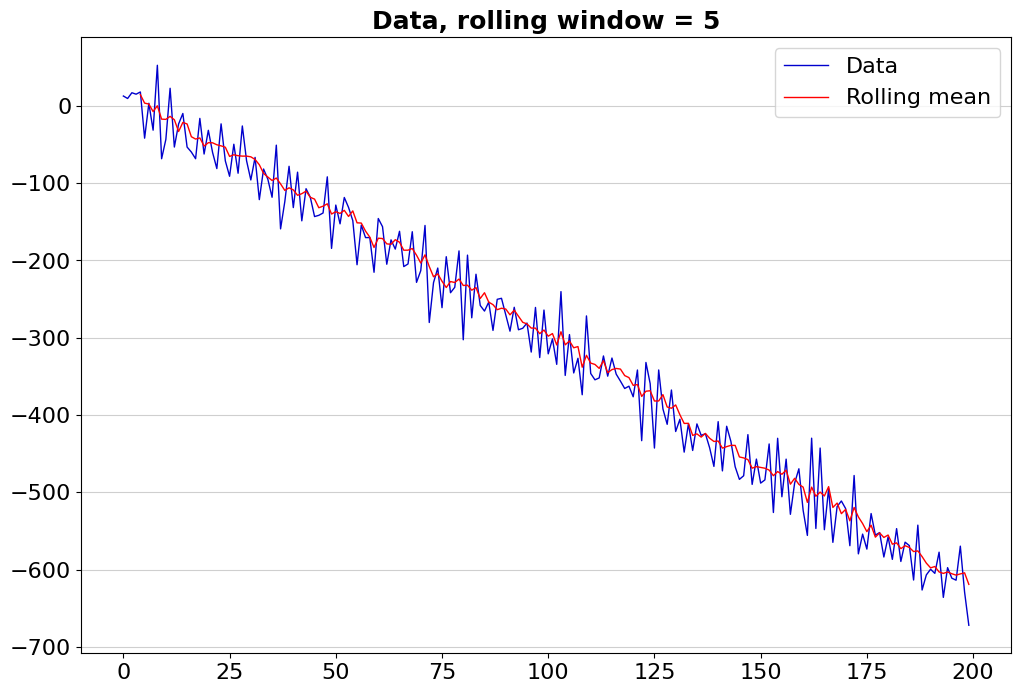

In [220]:
window = 5
plotting(time_series_df, f'Data, rolling window = {window}', (12, 8), window, std=False)

# Тесты на стационарность

**Среднее не является постоянным. Наблюдается ярко выраженный тренд**

In [6]:
def adf_test(time_series, maxlag=None, regression='c'):
    result = adfuller(time_series, maxlag=maxlag, regression=regression)
    print('ADF statistic: ', result[0])
    print('p-value: ', result[1])
    print('cricital values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[0] < result[4]['5%']:
        print('H_0 отвергнута: временной ряд является стационарным')
    else:
        print('H_0 не отвергнута: временной ряд является нестационарным')
    return result

def kpss_test(time_series, regression='c', nlags='auto'):
    '''
    The null hypothesis for the KPSS test.
    'c' : The data is stationary around a constant (default).
    'ct' : The data is stationary around a trend.
    '''
    result = kpss(time_series, regression=regression, nlags=nlags)
    print('KPSS statistic: ', result[0])
    print('p-value: ', result[1])
    print('cricital values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[0] > result[3]['5%']:
        print('H_0 отвергнута: временной ряд является нестационарным')
    else:
        print('H_0 не отвергнута: временной ряд является стационарным')
    return result

| **тест ADF** | **тест KPSS** |
| :--- | :--- |
| $H_0$ : временной ряд является нестационарным | $H_0$ : временной ряд является стационарным |
| - могут быть единичные корни | - может быть стационарный тренд |
| - DSP не отвергается | - TSP не отвергается |
| $H_A$ : временной ряд является стационарным | $H_A$ : временной ряд является нестационарным |
| - ряд не имеет единичных корней | - не имеет стационарного тренда |
| - может быть стационарный тренд | - могут быть единичные корни |
| - DSP отвергается | - TSP отвергается |

Интерпретация:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

[источник](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

Если в тесте p-value < 0.05, мы отвергаем нулевую гипотезу

картинкa [отсюда](https://www.bsu.by/upload/page/546923.pdf)

(-0.5, 1004.5, 753.5, -0.5)

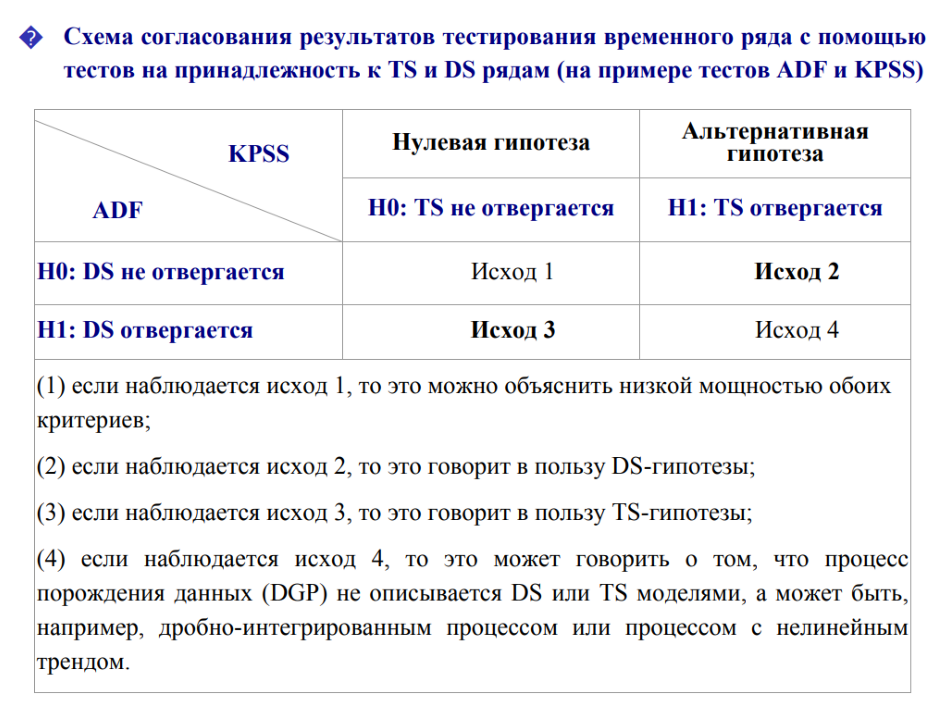

In [ ]:
plt.figure(figsize=(12, 10))
image = plt.imread('adf-kpss.PNG')
plt.imshow(image)
plt.axis('off')

In [7]:
regression = 'c'
lags = 0

result_adf = adf_test(time_series_np, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(time_series_np, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  0.18407458380582195
p-value:  0.9713541069675696
cricital values:
	1%: -3.4662005731940853
	5%: -2.8772932777920364
	10%: -2.575167750182615
H_0 не отвергнута: временной ряд является нестационарным
adf (0.18407458380582195, 0.9713541069675696, 14, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, 1712.2575789445436)

KPSS statistic:  2.1071220557178965
p-value:  0.01
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 отвергнута: временной ряд является нестационарным
kpss (2.1071220557178965, 0.01, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-6-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


In [8]:
regression = 'ct'
lags = 0

result_adf = adf_test(time_series_np, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(time_series_np, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -14.968805477618645
p-value:  2.2666169023033805e-22
cricital values:
	1%: -4.005235140049614
	5%: -3.4329000694219
	10%: -3.1402115863254525
H_0 отвергнута: временной ряд является стационарным
adf (-14.968805477618645, 2.2666169023033805e-22, 1, 198, {'1%': -4.005235140049614, '5%': -3.4329000694219, '10%': -3.1402115863254525}, 1696.5579013742142)

KPSS statistic:  0.1295943050523964
p-value:  0.08038091656963627
cricital values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
H_0 не отвергнута: временной ряд является стационарным
kpss (0.1295943050523964, 0.08038091656963627, 14, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



**`regression='c'`**
- ADF-тест: $H_0$ не отвергнута, временной ряд является нестационарным, DSP не отвергается
- KPSS-тест: p-value < 0.05, $H_0$ отвергнута, временной ряд является нестационарным, TSP отвергается

**`regression='ct'`**
- ADF-тест: p-value < 0.05, $H_0$ отвергнута, временной ряд является стационарным, DSP отвергается
- KPSS-тесты: $H_0$ не отвергнута, временной ряд является стационарным, TSP не отвергается

Изначально ряд нестационарный с намёком на DSP. После учёта тренда тесты говорят, что ряд стационарный относительно тренда и отвергают DSP. Рассмотрим оба случая TSP, DSP

# Коррелограммы исходного временного ряда

In [9]:
def correlogram_plotting(correlogram, time_series, nlags, figsize: tuple):
    # calculating
    if correlogram == 'acf':
        corr_values = acf(time_series, nlags=nlags)
        title = 'Sample ACF'
        ylabel = 'Sample Autocorrelation'
    elif correlogram == 'pacf':
        corr_values = pacf(time_series, nlags=nlags)
        title = 'Sample PACF'
        ylabel = 'Sample Partial Autocorrelation'

    x_ = np.arange(0, nlags+1)
    pos_interval = 1.96/np.sqrt(len(time_series))
    neg_interval = -1.96/np.sqrt(len(time_series))

    plt.figure(figsize=figsize)
    linewidth = 2
    markersize = figsize[0] * figsize[1]

    # vertical lines with markers
    plt.vlines(x_, ymin=0, ymax=corr_values, linewidth=linewidth, color='red')
    plt.scatter(x_, corr_values, s=markersize, color='red')

    # horizontal lines
    plt.hlines(0, xmin=-1, xmax=nlags+1, linewidth=1, color='black')
    plt.hlines(pos_interval, xmin=-1, xmax=nlags+1, linewidth=1, color='blue')
    plt.hlines(neg_interval, xmin=-1, xmax=nlags+1, linewidth=1, color='blue')

    # formatting and details
    plt.xlim(-1, nlags+1)
    plt.title(title, fontsize=sum(figsize), weight='bold')
    plt.xlabel('Lag', fontsize=sum(figsize)-2)
    plt.ylabel(ylabel, fontsize=sum(figsize)-2)
    plt.xticks(x_, fontsize=sum(figsize)-2)
    plt.yticks(fontsize=sum(figsize)-2)
    plt.grid(alpha=0.4)
    plt.show()

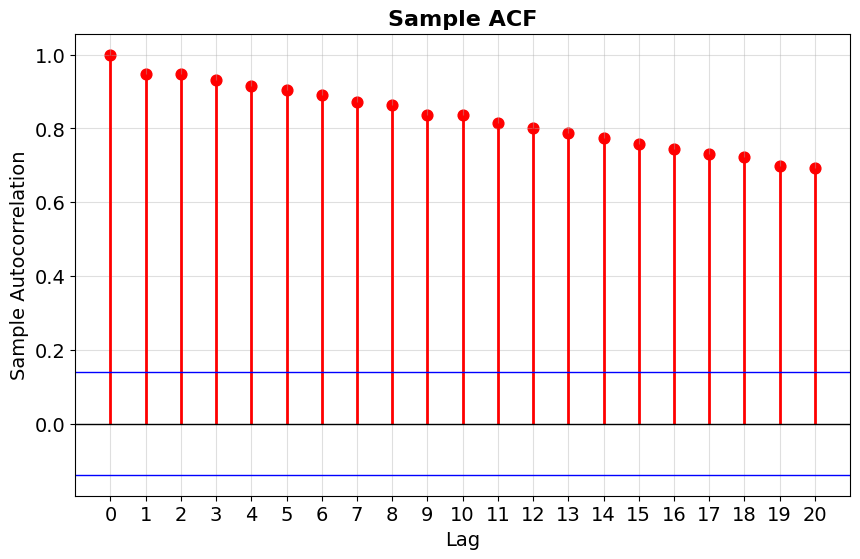

In [10]:
correlogram_plotting('acf', time_series_np, nlags=20, figsize=(10, 6))

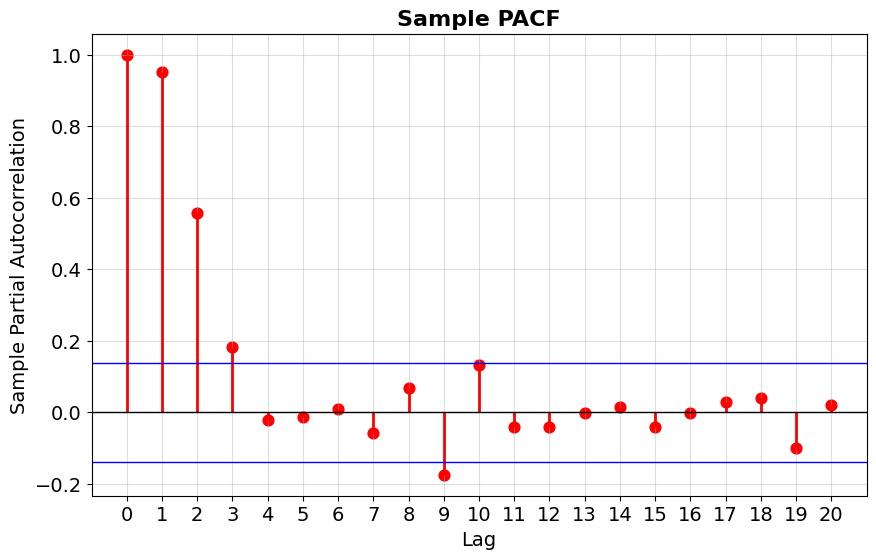

In [11]:
correlogram_plotting('pacf', time_series_np, nlags=20, figsize=(10, 6))

# Trend Stationary Process

## Оценим тренд МНК

In [35]:
y = time_series_np
x = np.arange(len(time_series_np))

trend_model = np.polyfit(x, y, 1)
theta_0 = trend_model[1]
theta_1 = trend_model[0]

y_pred_trend = np.polyval([theta_1, theta_0], x)
print('theta_0:', theta_0)
print('theta_1:', theta_1)
print('R2 score:', r2_score(y, y_pred_trend))
print('MAE score:', mean_absolute_error(y, y_pred_trend))

theta_0: 16.476972835820877
theta_1: -3.2275090787519685
R2 score: 0.9764014627858992
MAE score: 23.375290867882697


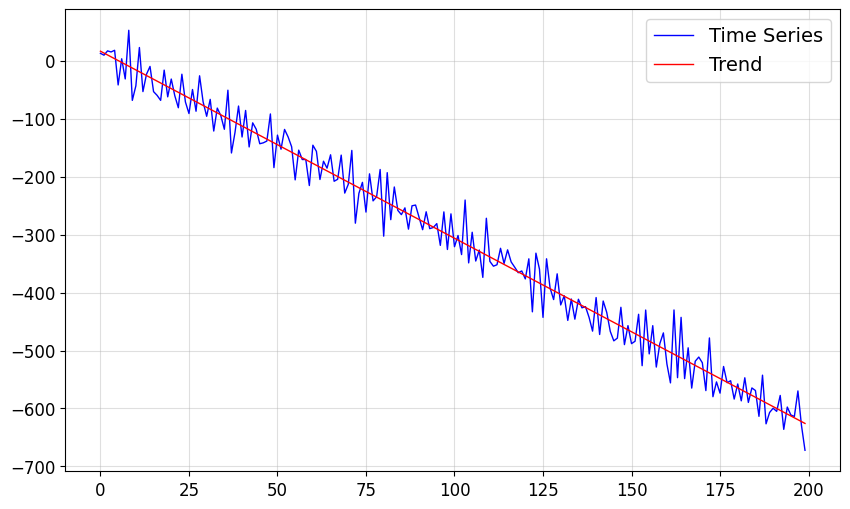

In [36]:
plt.figure(figsize=(10, 6))

plt.plot(x, y, linewidth=1, color='b', label='Time Series')
plt.plot(x, y_pred_trend, linewidth=1, color = 'r', label = 'Trend')

plt.legend(loc='best', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.4)

MAE between detrend_hand and detrend_auto = 1.7641887950503587e-13


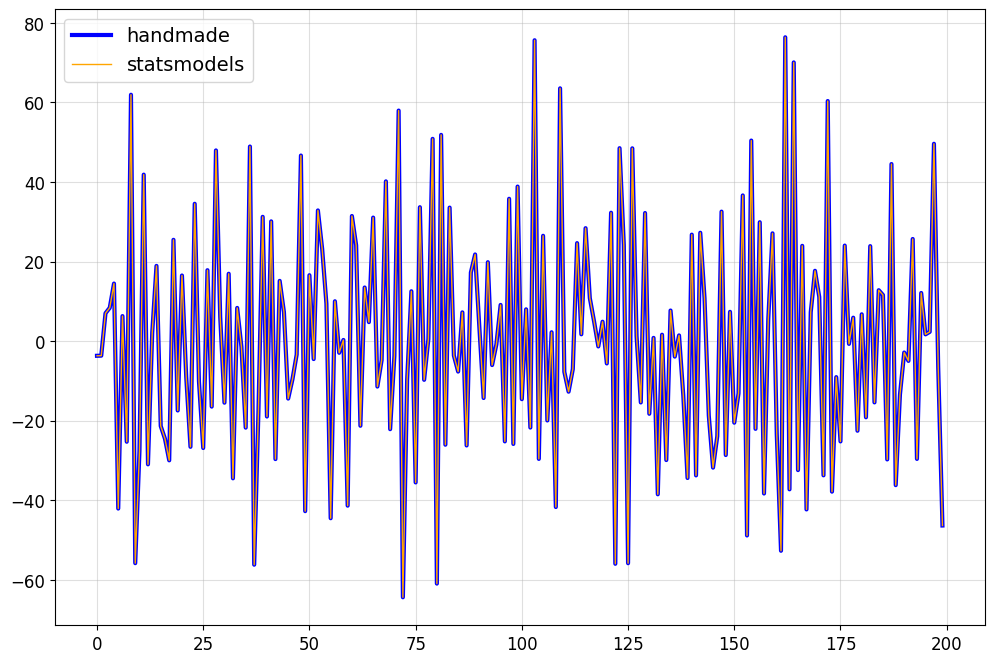

In [37]:
# детрендируем вручную
detrend_hand = time_series_np - y_pred_trend

# детрендируем с помощью statsmodels
detrend_auto = detrend(time_series_df, order=1, axis=0)

print(f'MAE between detrend_hand and detrend_auto = {mean_absolute_error(detrend_auto, detrend_hand)}')

plt.figure(figsize=(12, 8))

plt.plot(x, detrend_hand, linewidth=3, color='blue', label='handmade')
plt.plot(x, detrend_auto, linewidth=1, color='orange', label = 'statsmodels')

plt.legend(loc='best', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.4)

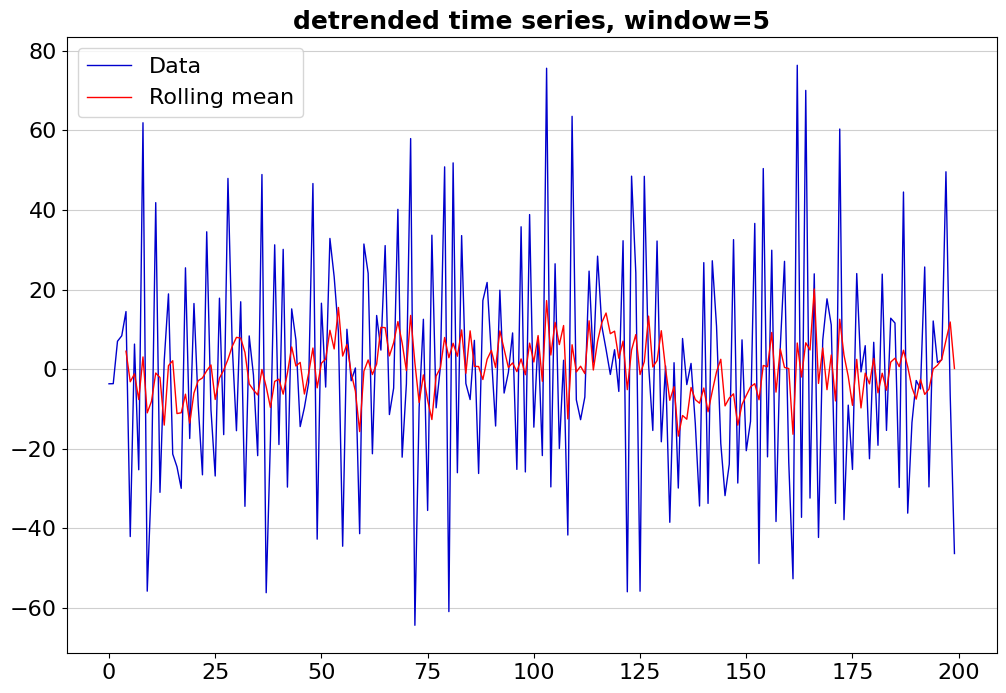

Выборочное среднее: 0   -2.042100e-13
dtype: float64


In [15]:
window = 5
plotting(detrend_auto, f'detrended time series, window={window}', (12, 8), window, std=False)
print(f'Выборочное среднее: {detrend_auto.mean()}')

In [16]:
regression = 'c'
lags = 0

result_adf = adf_test(detrend_auto, maxlag=lags, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(detrend_auto, regression=regression, nlags=lags)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -25.74794724438084
p-value:  0.0
cricital values:
	1%: -3.4636447617687436
	5%: -2.8761761179270766
	10%: -2.57457158581854
H_0 отвергнута: временной ряд является стационарным
adf (-25.74794724438084, 0.0, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 1839.4109329323828)

KPSS statistic:  0.03294170847650928
p-value:  0.1
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 не отвергнута: временной ряд является стационарным
kpss (0.03294170847650928, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-6-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


Оба теста говорят, что после детрендирования ряд является стационарным

## Коррелограммы детрендированного ряда

**Кажется, что есть сезонная компонента с периодом 10**

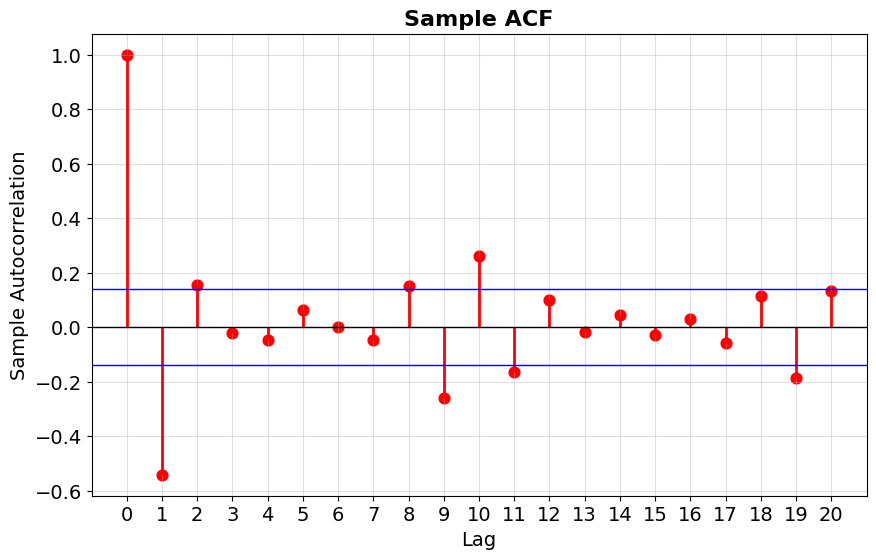

In [17]:
correlogram_plotting('acf', detrend_auto, nlags=20, figsize=(10, 6))

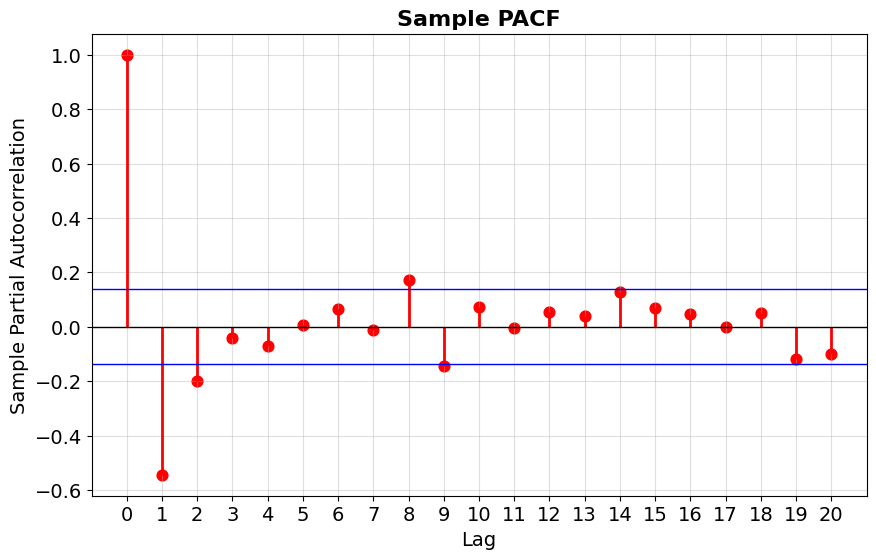

In [18]:
correlogram_plotting('pacf', detrend_auto, nlags=20, figsize=(10, 6))

**Несильно что-то меняется, если выделять сезонную компоненту и удалять её. Считаем, что сезонности нет**

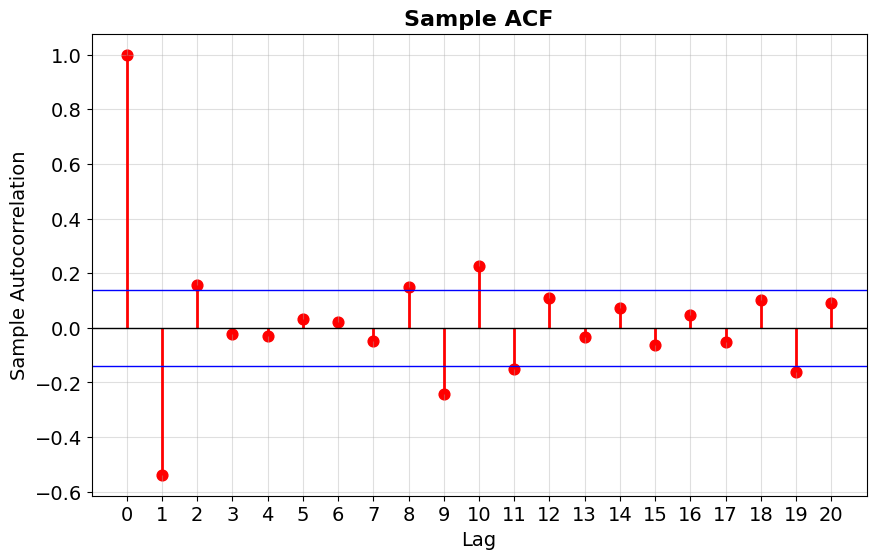

In [165]:
decompose_result = seasonal_decompose(detrend_auto, model='additive', period=10)
tmp = detrend_auto.to_numpy().ravel() - decompose_result.seasonal
correlogram_plotting('acf', tmp, nlags=20, figsize=(10, 6))

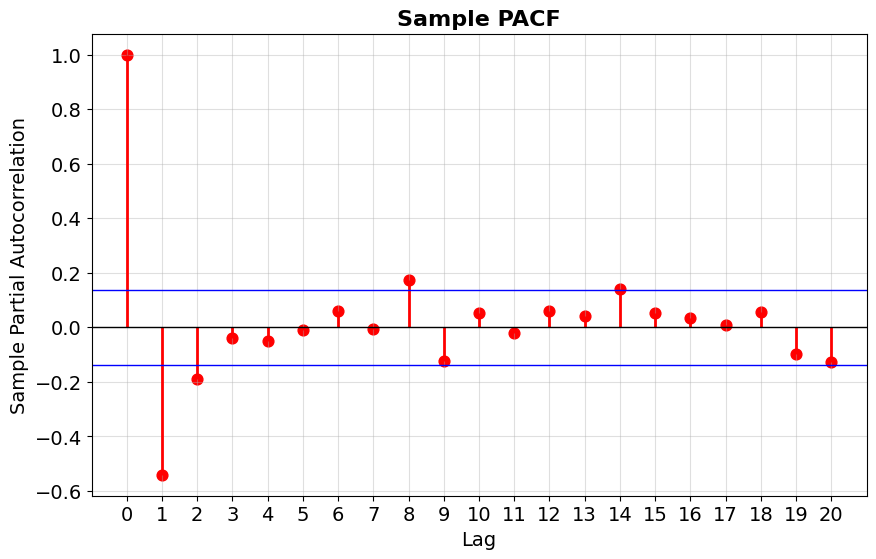

In [166]:
correlogram_plotting('pacf', tmp, nlags=20, figsize=(10, 6))

## Оценивание моделей

**Предлагаются модели: AR(2), AR(8), AR(9)**

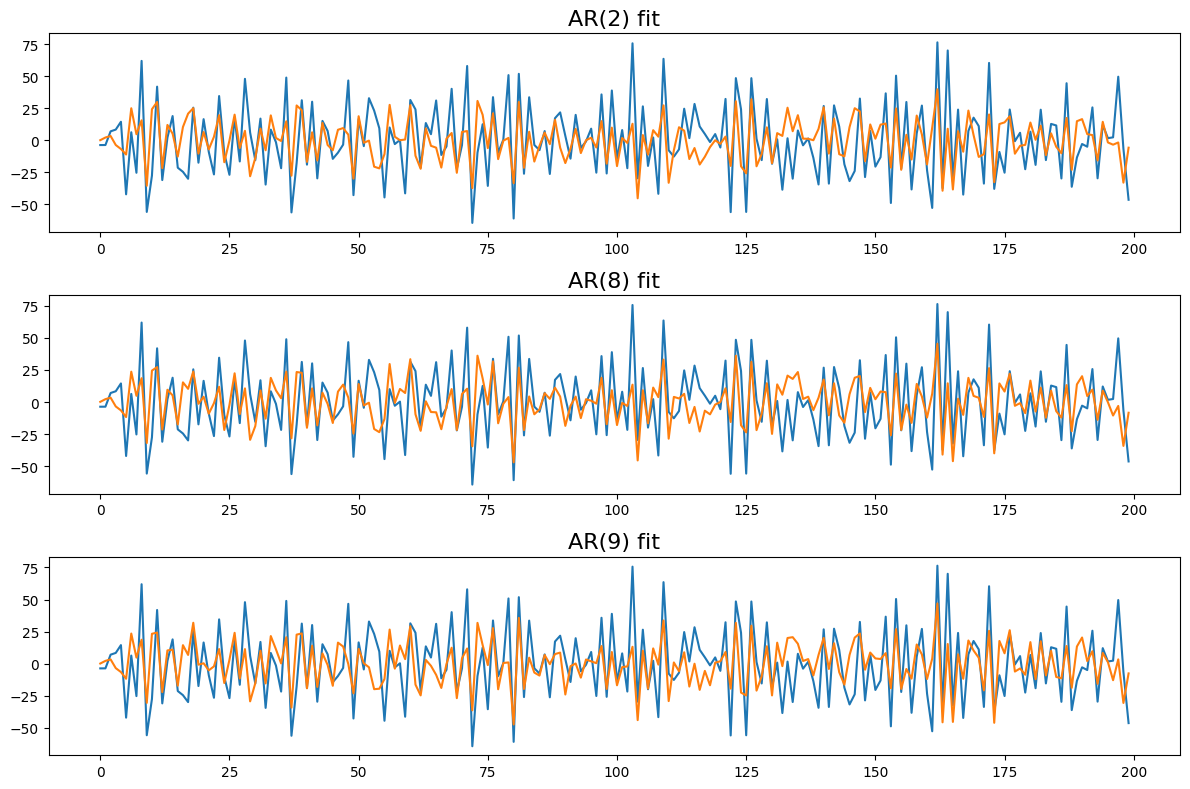

In [29]:
plt.figure(figsize=(12, 8))

ar_orders = [2, 8, 9]
order_aic_bic = []

for idx, ar_order in enumerate(ar_orders):
    ar_model = ARIMA(detrend_auto, order=(ar_order, 0, 0))
    ar_model_fit = ar_model.fit()
    order_aic_bic.append((ar_order, ar_model_fit.aic, ar_model_fit.bic))

    plt.subplot(len(ar_orders), 1, idx+1)
    plt.plot(detrend_auto)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) fit'%ar_order, fontsize=16)

plt.tight_layout()

In [20]:
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'aic', 'bic'])
order_df

,p,aic,bic
0,2,1843.396404,1856.589673
1,8,1847.787260,1880.770434
2,9,1845.928035,1882.209526


In [21]:
print(order_df.sort_values('aic'))
print()
print(order_df.sort_values('bic'))

   p          aic          bic
0  2  1843.396404  1856.589673
2  9  1845.928035  1882.209526
1  8  1847.787260  1880.770434

   p          aic          bic
0  2  1843.396404  1856.589673
1  8  1847.787260  1880.770434
2  9  1845.928035  1882.209526


**Итоговая модель: AR(2)**

## Проверка белошумности остатков

**Удалим из ряда оцененный тренд и модель AR(2) с оценёнными параметрами**

In [22]:
model = ARIMA(detrend_auto, order=(2,0,0)).fit()
AR_2 = np.array(model.fittedvalues)
detrended = detrend_auto.to_numpy().ravel()
residuals = detrended - AR_2

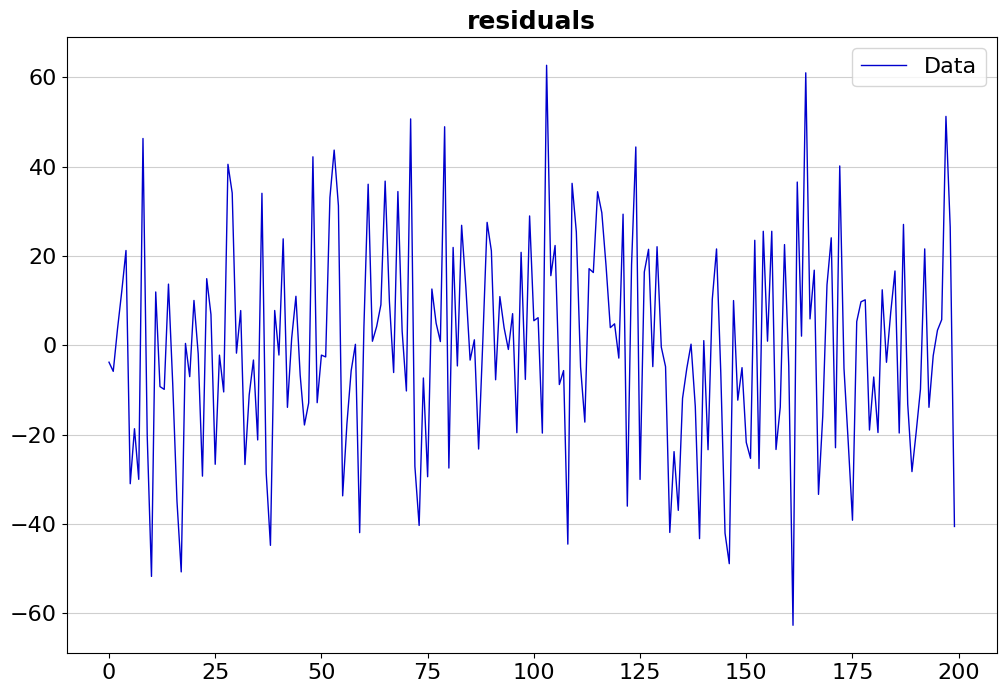

In [23]:
plotting(residuals, 'residuals', (12, 8))

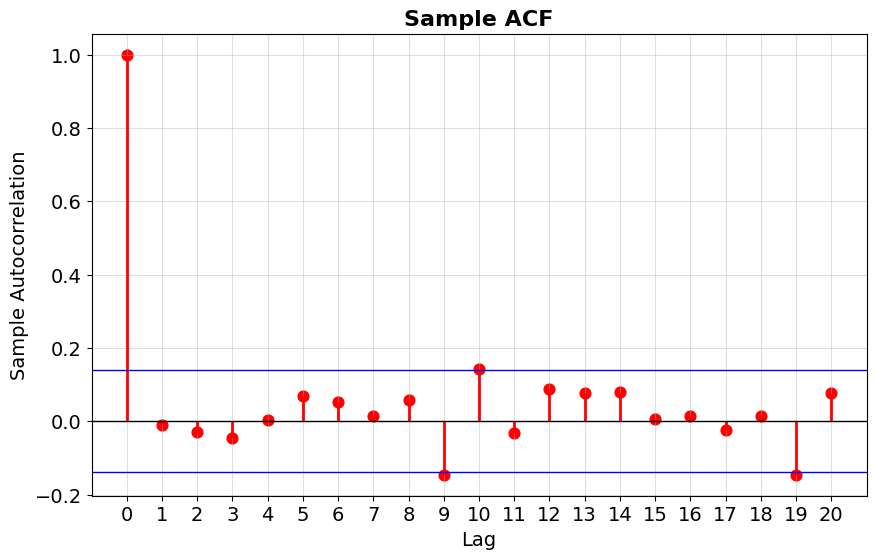

In [24]:
correlogram_plotting('acf', residuals, 20, (10, 6))

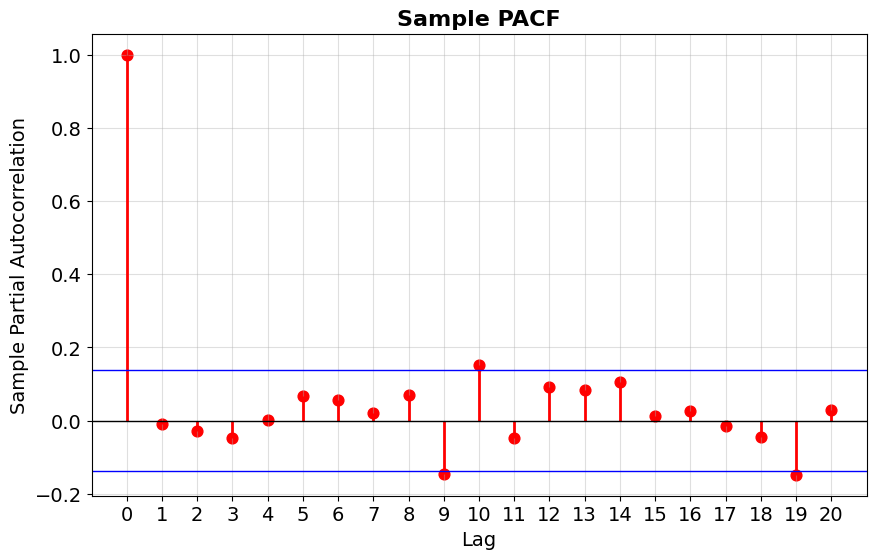

In [25]:
correlogram_plotting('pacf', residuals, 20, (10, 6))

**ADF и KPSS тесты и их p-value говорят, что остатки стационарны**

In [26]:
regression = 'c'
lags = 0

result_adf = adf_test(residuals, maxlag=lags, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(residuals, regression=regression, nlags=lags)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -14.07362211003423
p-value:  2.910790897691136e-26
cricital values:
	1%: -3.4636447617687436
	5%: -2.8761761179270766
	10%: -2.57457158581854
H_0 отвергнута: временной ряд является стационарным
adf (-14.07362211003423, 2.910790897691136e-26, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 1830.74254360021)

KPSS statistic:  0.15037933421418204
p-value:  0.1
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 не отвергнута: временной ряд является стационарным
kpss (0.15037933421418204, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-6-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


**Критерии Люнга-Бокса и Бокса-Пирса говорят, что остатки белошумны**

In [27]:
acorr_ljungbox(residuals, lags=20, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.019744,0.888254,0.019451,0.889081
2,0.189413,0.909640,0.185760,0.911303
3,0.640474,0.887107,0.625656,0.890535
4,0.642680,0.958205,0.627796,0.959925
5,1.592031,0.902211,1.544250,0.907908
6,2.191849,0.901236,2.120312,0.908307
7,2.239030,0.945435,2.165391,0.950122
8,2.918690,0.939356,2.811405,0.945630
9,7.413254,0.594176,7.061215,0.630746
10,11.684652,0.306716,11.078866,0.351407


## Прогноз на один шаг

In [208]:
x_values_for_predict = np.arange(len(time_series_np) + 1)
trend_values = np.polyval([theta_1, theta_0], x_values_for_predict)

In [209]:
model = ARIMA(detrend_auto, order=(2,0,0)).fit()
model_predict = np.array(model.predict())
stochastic_component_with_trend = trend_values[:-1] + model_predict + residuals

In [210]:
one_step_predict = model.predict(start=199, end=200).values
one_step_predict[0] = stochastic_component_with_trend[-1]
one_step_predict[1] += trend_values[-1]
print(one_step_predict[1])

-596.8874484542794


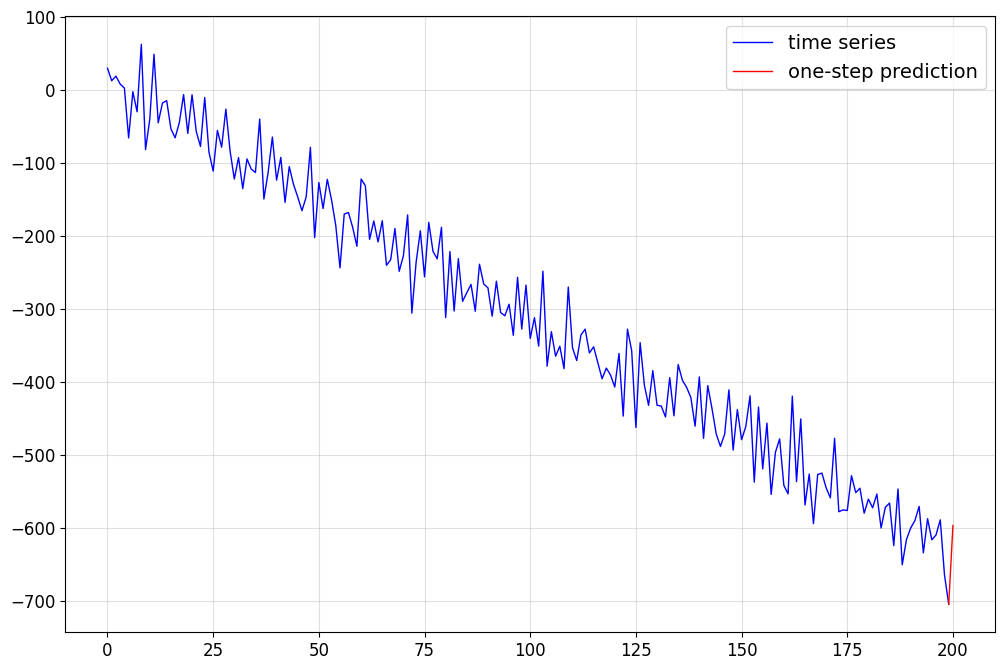

In [211]:
plt.figure(figsize=(12, 8))

plt.plot(stochastic_component_with_trend, linewidth=1, color='blue', label='time series')
plt.plot([199, 200], one_step_predict, linewidth=1, color='red', label='one-step prediction')

plt.legend(loc='best', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.4)

plt.show()

# Difference Stationary Process

## Попробуем сделать ряд стационарным взятием первых разностей

In [142]:
time_series_diff_df = time_series_df.diff(periods=1).dropna()
time_series_diff_np = time_series_diff_df.to_numpy().ravel()

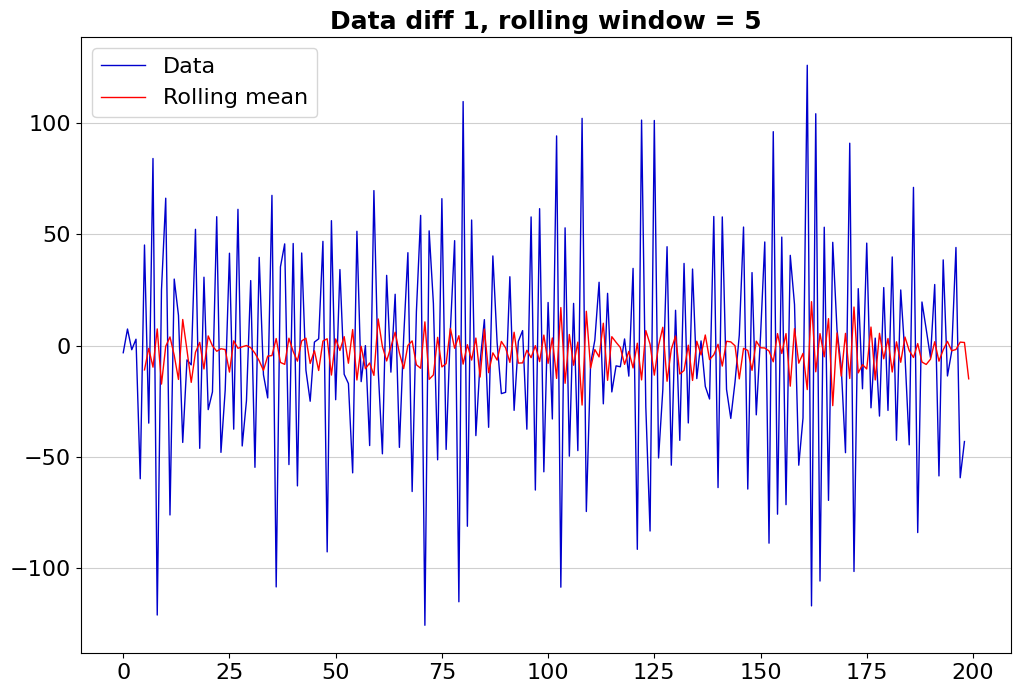

In [143]:
window = 5
plotting(time_series_diff_df, f'Data diff 1, rolling window = {window}', (12, 8), window, std=False)

In [144]:
regression = 'c'
lags = 0

result_adf = adf_test(time_series_diff_np, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(time_series_diff_np, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -7.136894372509839
p-value:  3.4026284040429673e-10
cricital values:
	1%: -3.4662005731940853
	5%: -2.8772932777920364
	10%: -2.575167750182615
H_0 отвергнута: временной ряд является стационарным
adf (-7.136894372509839, 3.4026284040429673e-10, 13, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, 1699.1827082620362)

KPSS statistic:  0.2540029336486412
p-value:  0.1
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 не отвергнута: временной ряд является стационарным
kpss (0.2540029336486412, 0.1, 62, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-6-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


**`regression='c'`**
- ADF-тест: p-value < 0.05 $H_0$ отвергнута, временной ряд является стационарным, DSP отвергается
- KPSS-тест: $H_0$ не отвергнута, временной ряд является стационарным, TSP не отвергается

## Коррелограммы

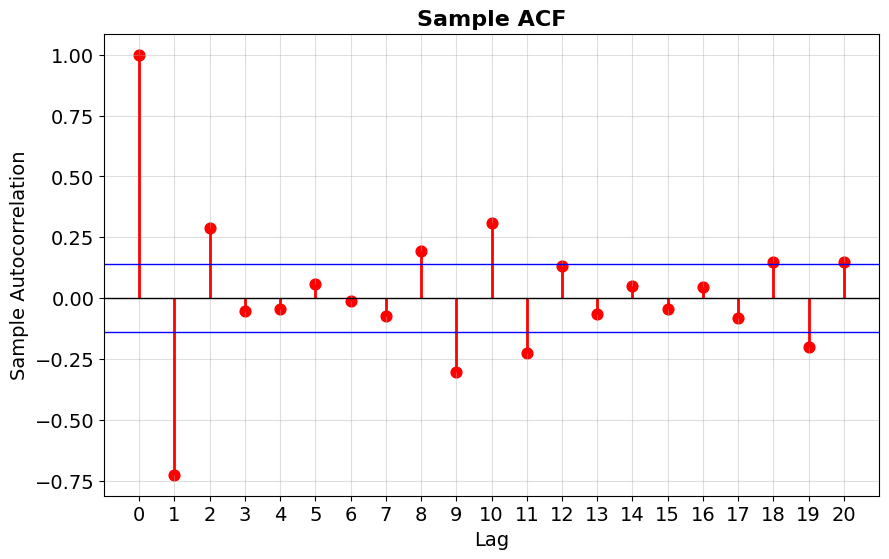

In [146]:
correlogram_plotting('acf', time_series_diff_np, nlags=20, figsize=(10, 6))

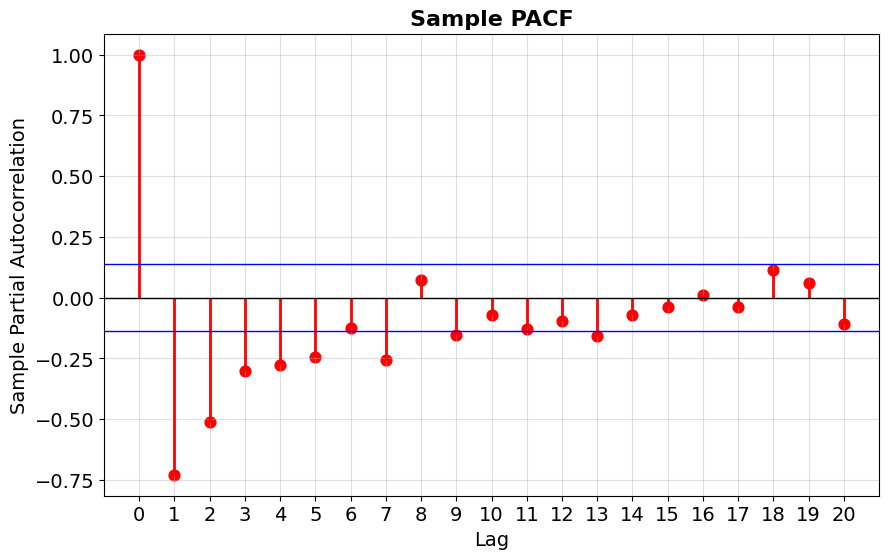

In [147]:
correlogram_plotting('pacf', time_series_diff_np, nlags=20, figsize=(10, 6))

## Оценивание моделей

**Предлагаются модели: AR(5), AR(7), AR(9)**

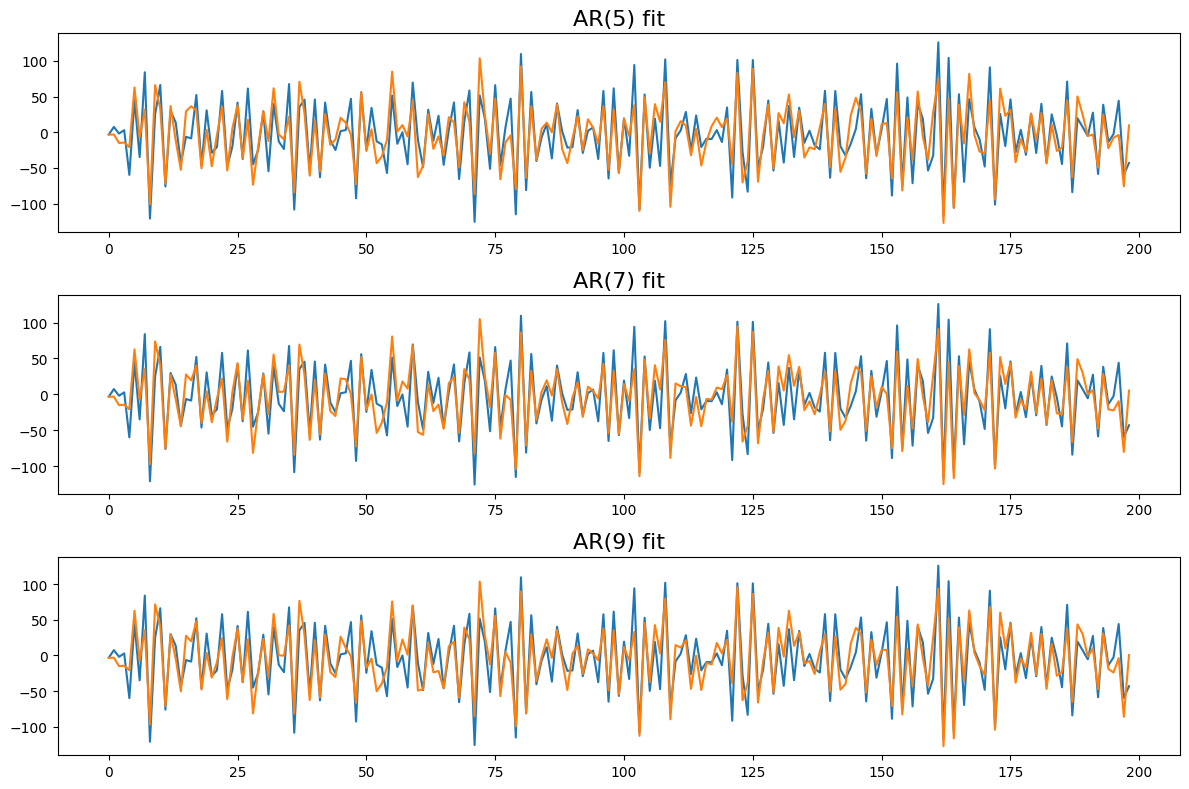

In [167]:
# ARMA(p, 0)
plt.figure(figsize=(12, 8))

ar_orders = [5, 7, 9]
order_aic_bic = []

for idx, ar_order in enumerate(ar_orders):
    ar_model = ARIMA(time_series_diff_np, order=(ar_order, 0, 0))
    ar_model_fit = ar_model.fit()
    order_aic_bic.append((ar_order, ar_model_fit.aic, ar_model_fit.bic))

    plt.subplot(len(ar_orders), 1, idx+1)
    plt.plot(time_series_diff_np)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) fit'%ar_order, fontsize=16)

plt.tight_layout()

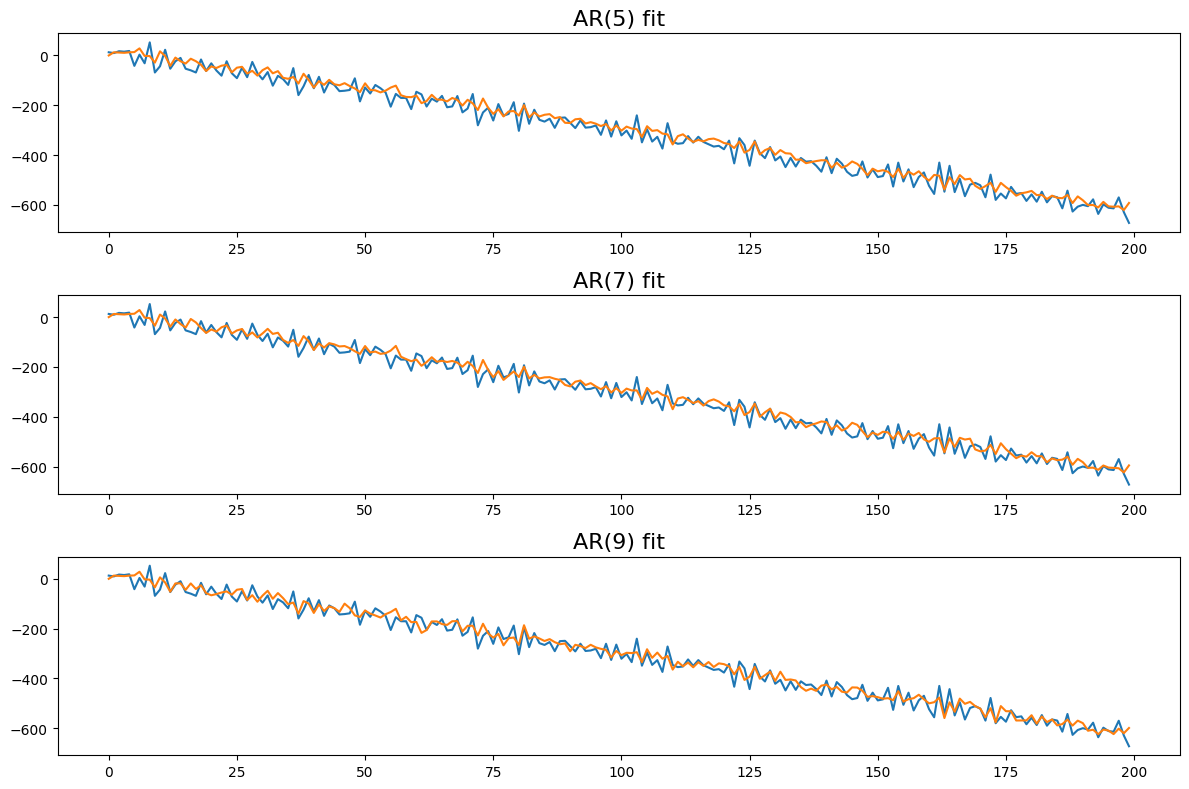

In [168]:
# ARIMA(p, 1, 0)
plt.figure(figsize=(12, 8))

ar_orders = [5, 7, 9]
order_aic_bic_I = []

for idx, ar_order in enumerate(ar_orders):
    ar_model = ARIMA(time_series_np, order=(ar_order, 1, 0))
    ar_model_fit = ar_model.fit()
    order_aic_bic_I.append((ar_order, ar_model_fit.aic, ar_model_fit.bic))

    plt.subplot(len(ar_orders), 1, idx+1)
    plt.plot(time_series_np)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) fit'%ar_order, fontsize=16)

plt.tight_layout()

In [170]:
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'aic', 'bic'])
print(order_df.sort_values('aic'))
print()
print(order_df.sort_values('bic'))

   p          aic          bic
2  9  1856.938485  1893.164838
1  7  1858.709172  1888.348915
0  5  1875.492525  1898.545659

   p          aic          bic
1  7  1858.709172  1888.348915
2  9  1856.938485  1893.164838
0  5  1875.492525  1898.545659


In [171]:
order_df_I = pd.DataFrame(order_aic_bic_I, columns=['p', 'aic', 'bic'])
print(order_df.sort_values('aic'))
print()
print(order_df.sort_values('bic'))

   p          aic          bic
2  9  1856.938485  1893.164838
1  7  1858.709172  1888.348915
0  5  1875.492525  1898.545659

   p          aic          bic
1  7  1858.709172  1888.348915
2  9  1856.938485  1893.164838
0  5  1875.492525  1898.545659


**Итоговая модель: ARIMA(9, 1, 0)**

## Проверка белошумности остатков

**Удалим из ряда модель ARIMA(9, 1, 0) с оценёнными параметрами**

In [196]:
model = ARIMA(time_series_np, order=(9,1,0)).fit()
ARIMA_9_1 = np.array(model.fittedvalues)
residuals = time_series_np - ARIMA_9_1

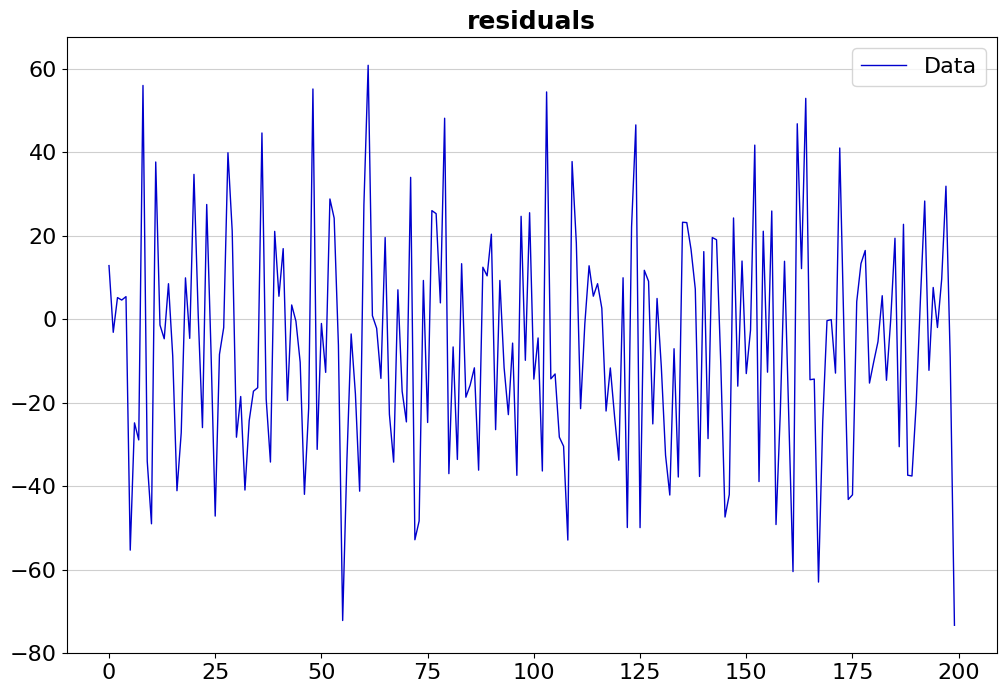

In [191]:
plotting(residuals, 'residuals', (12, 8))

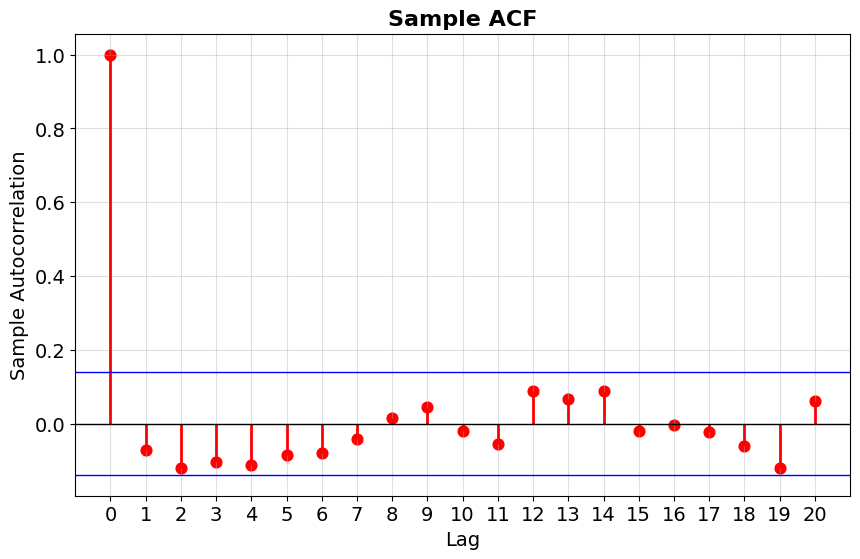

In [192]:
correlogram_plotting('acf', residuals, 20, (10, 6))

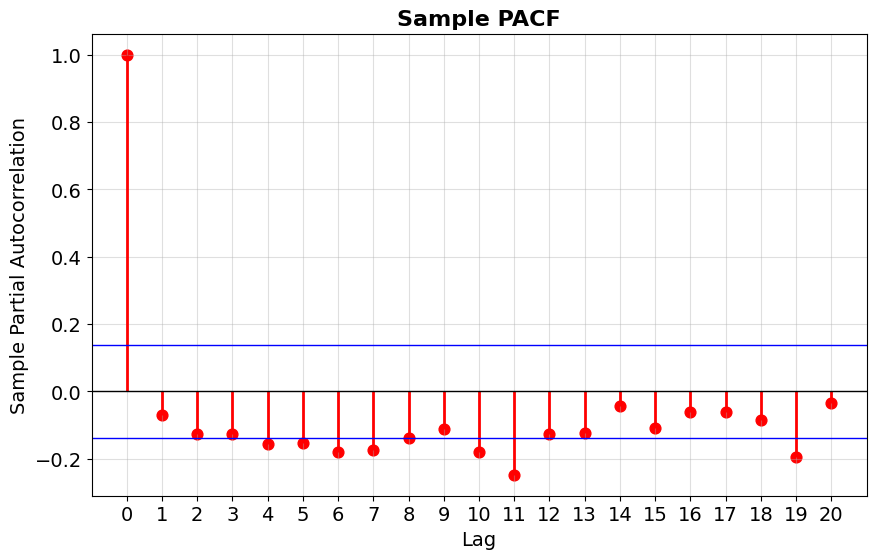

In [193]:
correlogram_plotting('pacf', residuals, 20, (10, 6))

**ADF и KPSS тесты и их p-value говорят, что остатки стационарны**

In [194]:
regression = 'c'
lags = 0

result_adf = adf_test(residuals, maxlag=lags, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(residuals, regression=regression, nlags=lags)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -14.876625635688985
p-value:  1.6328463765441124e-27
cricital values:
	1%: -3.4636447617687436
	5%: -2.8761761179270766
	10%: -2.57457158581854
H_0 отвергнута: временной ряд является стационарным
adf (-14.876625635688985, 1.6328463765441124e-27, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 1881.5176065348023)

KPSS statistic:  0.006515954290133251
p-value:  0.1
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 не отвергнута: временной ряд является стационарным
kpss (0.006515954290133251, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-6-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


**Критерии Люнга-Бокса и Бокса-Пирса говорят, что остатки являются белым шумом. Не так уверенно, как в TSP, но говорят**



In [195]:
acorr_ljungbox(residuals, lags=20, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,1.008699,0.315215,0.993718,0.318835
2,3.915240,0.141194,3.842704,0.146409
3,6.164997,0.103853,6.036774,0.109835
4,8.710262,0.068764,8.506437,0.074692
5,10.202614,0.069694,9.947074,0.076749
6,11.559860,0.072540,11.250568,0.080934
7,11.927733,0.102961,11.602050,0.114429
8,11.983755,0.151930,11.655299,0.167259
9,12.411766,0.191078,12.060003,0.209948
10,12.495880,0.253238,12.139120,0.275854


## Прогноз на один шаг

In [212]:
model = ARIMA(time_series_np, order=(7,1,0)).fit()
model_predict = np.array(model.predict())
stochastic_component = model_predict + residuals

In [213]:
one_step_predict = model.predict(start=199, end=200)
one_step_predict[0] = stochastic_component[-1]
print(one_step_predict[1])

-583.1512756126432


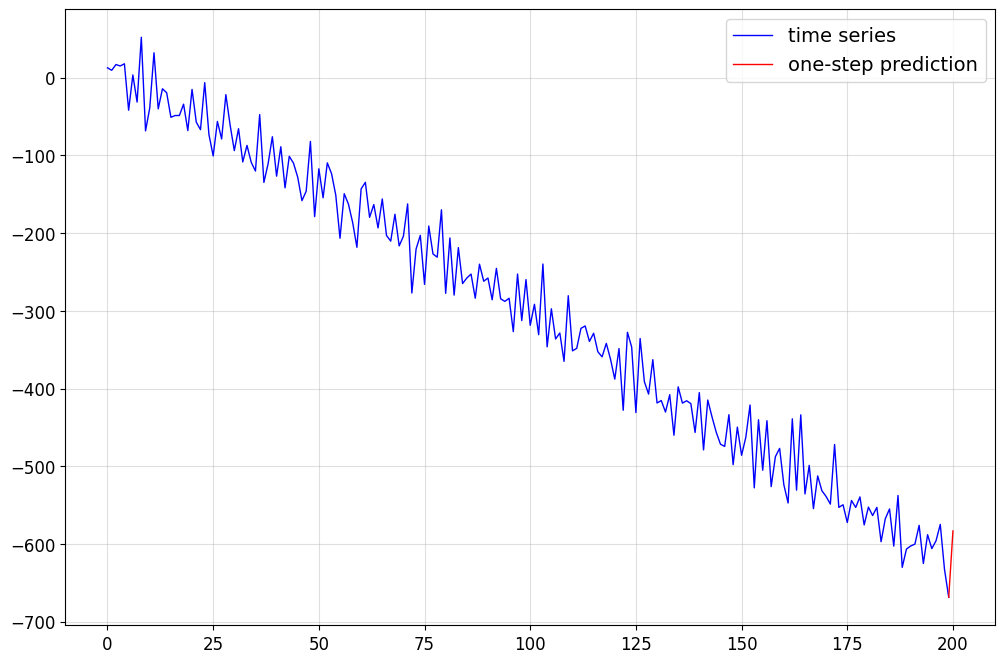

In [214]:
plt.figure(figsize=(12, 8))

plt.plot(stochastic_component, linewidth=1, color='blue', label='time series')
plt.plot([199, 200], one_step_predict, linewidth=1, color='red', label='one-step prediction')

plt.legend(loc='best', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.4)

plt.show()